In [9]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from pathlib import Path
import matplotlib as mpl

import sys, os
sys.path.append(os.path.abspath("../../.."))

from Forward.grav3D import grav3D_8091
from Forward.utils import calculateKernelGrav

In [10]:
# 1) Modelo (Δρ)
# - El NPZ trae contraste de densidad Δρ en g/cm^3
# - El kernel/forward trabaja en SI, así que convertimos a kg/m^3:
#   1 g/cm^3 = 1000 kg/m^3

model_npz = np.load(r"D:\8091_project\P8091\models\Toy2\Toy2_Grav.npz")

cell_centers  = model_npz["cell_centers"].astype(np.float32)  # (nC,3) [m]
delta_rho_gcc = model_npz["Grav_model"].astype(np.float32)    # (nC,) Δρ [g/cm^3]

delta_rho_kgm3 = delta_rho_gcc * 1000.0                       # (nC,) Δρ [kg/m^3] (SI)

dx = float(model_npz["dx"])  # [m]
dy = float(model_npz["dy"])  # [m]
dz = float(model_npz["dz"])  # [m]

full_mesh = {"cell_centers": cell_centers, "dx": dx, "dy": dy, "dz": dz}

density_contrast_active = torch.as_tensor(delta_rho_kgm3, dtype=torch.float32)

# 2) Receptores
obs_xyz = np.load(r"D:\8091_project\P8091\Examples\Modelling\Grav_Toy2\receivers_location.npy")  # [m]


In [11]:
# 3) Kernel

kernelcal, centers_v = calculateKernelGrav(
    density_contrast_model=density_contrast_active,
    mesh=full_mesh,
    receiver_locations=obs_xyz
)

In [12]:
# 4) Forward

gz_custom_mgal = grav3D_8091(
    density_contrast_model=density_contrast_active,
    K=kernelcal,
    to_mgal=True
)

data_torch = gz_custom_mgal.detach().cpu().numpy().ravel()
locs_torch = obs_xyz[:, :2]

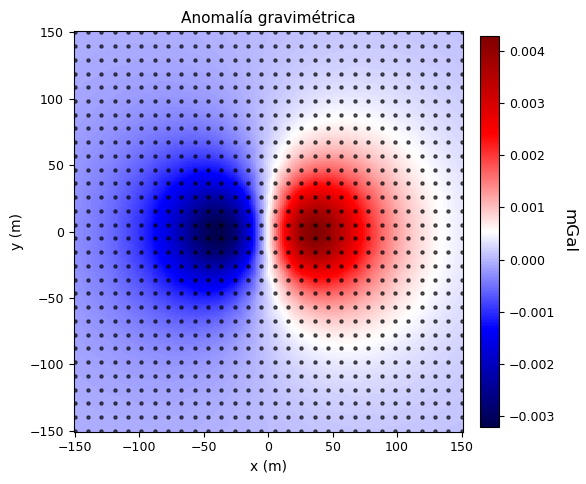

In [13]:
# 5) Plot

valid = np.isfinite(data_torch)
vmin_t, vmax_t = data_torch[valid].min(), data_torch[valid].max()
cmap = "seismic"

def plot_scattered_field(ax, locs, values, vmin, vmax, title, cmap="seismic", nx=200, ny=200):
    x, y = locs[:, 0], locs[:, 1]
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    XI, YI = np.meshgrid(xi, yi)

    interp = LinearNDInterpolator(np.c_[x, y], values)
    Zi = interp(XI, YI)

    im = ax.pcolormesh(XI, YI, Zi, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.scatter(x, y, s=5, c="k", alpha=0.6)
    return im

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
mappable = plot_scattered_field(
    ax, locs_torch, data_torch,
    vmin=vmin_t, vmax=vmax_t,
    title="Anomalía gravimétrica",
    cmap=cmap
)

cbar = fig.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mGal", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

C:\Users\aapm1\AppData\Local\Temp\ipykernel_6768\319515938.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_model = mpl.cm.get_cmap("viridis").copy()
C:\Users\aapm1\AppData\Local\Temp\ipykernel_6768\319515938.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.06, 0.06, 0.94, 0.98])


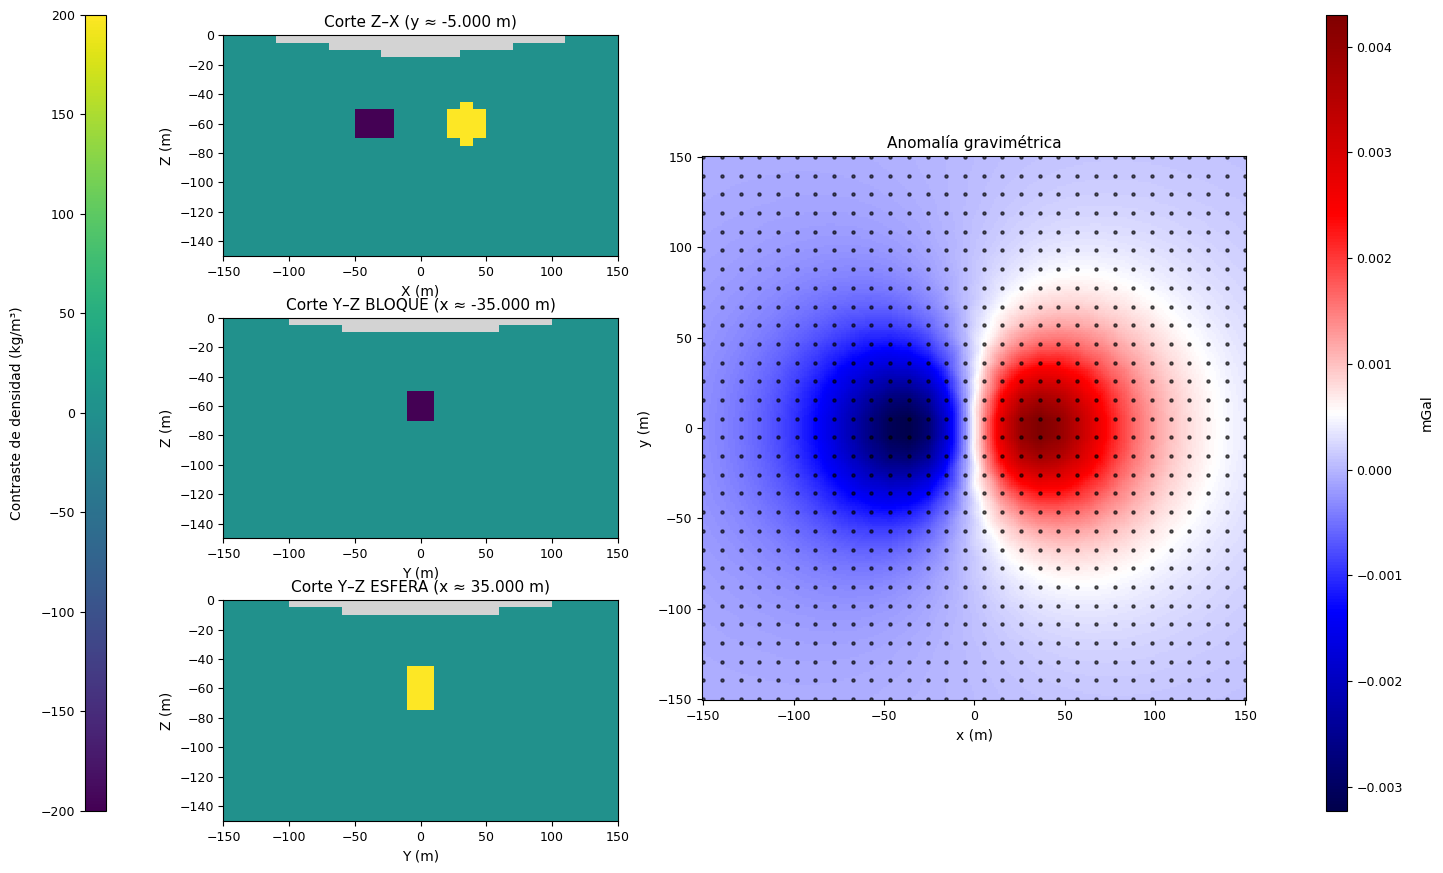

Guardado: D:\8091_project\P8091\Examples\Modelling\Grav_Toy2\Modeling_Toy2.png


In [14]:
mpl.rcParams.update({
    "font.size": 12, "axes.titlesize": 11, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
})

block_xmin, block_xmax = -50.0, -20.0
block_ymin, block_ymax = -15.0,  15.0
block_zmin, block_zmax = -70.0, -50.0  # (más negativo = más profundo)

sphere_center = np.array([35.0, 0.0, -60.0], dtype=float)
sphere_radius = 14.0

rho_active_np = density_contrast_active.detach().cpu().numpy().ravel()

cent = np.asarray(cell_centers, float)
if cent.ndim != 2 or cent.shape[1] != 3:
    raise ValueError(f"cell_centers debe ser (nC,3). Llegó: {cent.shape}")
if rho_active_np.size != cent.shape[0]:
    raise RuntimeError(f"rho y cell_centers no coinciden: {rho_active_np.size} vs {cent.shape[0]}")

x_c, y_c, z_c = cent[:, 0], cent[:, 1], cent[:, 2]

x_unique = np.unique(x_c); x_unique.sort()
y_unique = np.unique(y_c); y_unique.sort()
z_unique = np.unique(z_c); z_unique.sort()

nx, ny, nz = len(x_unique), len(y_unique), len(z_unique)

# Mapear centros -> índices
ix = np.searchsorted(x_unique, x_c)
iy = np.searchsorted(y_unique, y_c)
iz = np.searchsorted(z_unique, z_c)

# Chequeo por redondeo
tolx = toly = tolz = 1e-4
bad = (
    (np.abs(x_unique[ix] - x_c) > tolx) |
    (np.abs(y_unique[iy] - y_c) > toly) |
    (np.abs(z_unique[iz] - z_c) > tolz)
)
if np.any(bad):
    i0 = np.where(bad)[0][0]
    raise RuntimeError(
        "Hay cell_centers que no caen exactamente en los ejes únicos (posible redondeo).\n"
        f"Ejemplo i={i0}: (x,y,z)=({x_c[i0]},{y_c[i0]},{z_c[i0]}) vs "
        f"(xu,yu,zu)=({x_unique[ix[i0]]},{y_unique[iy[i0]]},{z_unique[iz[i0]]})"
    )

rho_3d = np.full((nz, ny, nx), np.nan, dtype=float)
rho_3d[iz, iy, ix] = rho_active_np  # (nz,ny,nx)

def nearest_index(axis_vals, target):
    axis_vals = np.asarray(axis_vals, float)
    return int(np.argmin(np.abs(axis_vals - float(target))))

iy_slice = nearest_index(y_unique, 0.0)
y_slice_value = float(y_unique[iy_slice])

# Y–Z para el bloque: x en el centro del bloque
x_mid_block = 0.5 * (block_xmin + block_xmax)  # -35
ix_block = nearest_index(x_unique, x_mid_block)
x_block_value = float(x_unique[ix_block])

# Y–Z para la esfera: x del centro de esfera
ix_sphere = nearest_index(x_unique, sphere_center[0])
x_sphere_value = float(x_unique[ix_sphere])

# Cortes
rho_xz = rho_3d[:, iy_slice, :]         # (nz, nx)
rho_yz_block = rho_3d[:, :, ix_block]   # (nz, ny)
rho_yz_sphere = rho_3d[:, :, ix_sphere] # (nz, ny)

dx_m = np.median(np.diff(x_unique)) if nx > 1 else 1.0
dy_m = np.median(np.diff(y_unique)) if ny > 1 else 1.0
dz_m = np.median(np.diff(z_unique)) if nz > 1 else 1.0

x_edges = np.r_[x_unique[0] - dx_m/2, x_unique + dx_m/2]  # (nx+1,)
y_edges = np.r_[y_unique[0] - dy_m/2, y_unique + dy_m/2]  # (ny+1,)
z_edges = np.r_[z_unique[0] - dz_m/2, z_unique + dz_m/2]  # (nz+1,)

# Colormap modelo
rho_min = float(np.nanmin(rho_active_np))
rho_max = float(np.nanmax(rho_active_np))

cmap_model = mpl.cm.get_cmap("viridis").copy()
cmap_model.set_bad(color="lightgrey")
norm_model = mpl.colors.Normalize(vmin=rho_min, vmax=rho_max)

C_xz = np.ma.masked_invalid(rho_xz)               # (nz,nx)
C_yz_block = np.ma.masked_invalid(rho_yz_block)   # (nz,ny)
C_yz_sphere = np.ma.masked_invalid(rho_yz_sphere) # (nz,ny)

locs_torch = np.asarray(obs_xyz[:, :2], float)
data_torch = gz_custom_mgal.detach().cpu().numpy().ravel()

valid_torch = (
    np.isfinite(data_torch) &
    np.isfinite(locs_torch[:, 0]) &
    np.isfinite(locs_torch[:, 1])
)
locs_torch = locs_torch[valid_torch]
data_torch = data_torch[valid_torch]

vmin_t = float(data_torch.min())
vmax_t = float(data_torch.max())

def plot_scattered_field(ax, locs, values, vmin, vmax, title, cmap="seismic", nx=250, ny=250):
    x = locs[:, 0]
    y = locs[:, 1]

    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    XI, YI = np.meshgrid(xi, yi)

    interp = LinearNDInterpolator(np.c_[x, y], values)
    Zi = interp(XI, YI)

    im = ax.pcolormesh(XI, YI, Zi, shading="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.scatter(x, y, s=5, c="k", alpha=0.6)
    ax.set_aspect("equal", adjustable="box")
    return im

fig = plt.figure(figsize=(13.2, 10.2))
gs = fig.add_gridspec(
    3, 2,
    width_ratios=[1.05, 1.45],
    height_ratios=[1.0, 1.0, 1.0],
    wspace=0.18, hspace=0.28
)

ax_zx       = fig.add_subplot(gs[0, 0])
ax_yz_blk   = fig.add_subplot(gs[1, 0], sharey=ax_zx)
ax_yz_sph   = fig.add_subplot(gs[2, 0], sharey=ax_zx)
ax_map      = fig.add_subplot(gs[:, 1])

pm_zx = ax_zx.pcolormesh(x_edges, z_edges, C_xz, cmap=cmap_model, norm=norm_model, shading="flat")
ax_zx.set_title(f"Corte Z–X (y ≈ {y_slice_value:.3f} m)")
ax_zx.set_xlabel("X (m)")
ax_zx.set_ylabel("Z (m)")

pm_yz_blk = ax_yz_blk.pcolormesh(y_edges, z_edges, C_yz_block, cmap=cmap_model, norm=norm_model, shading="flat")
ax_yz_blk.set_title(f"Corte Y–Z BLOQUE (x ≈ {x_block_value:.3f} m)")
ax_yz_blk.set_xlabel("Y (m)")
ax_yz_blk.set_ylabel("Z (m)")

pm_yz_sph = ax_yz_sph.pcolormesh(y_edges, z_edges, C_yz_sphere, cmap=cmap_model, norm=norm_model, shading="flat")
ax_yz_sph.set_title(f"Corte Y–Z ESFERA (x ≈ {x_sphere_value:.3f} m)")
ax_yz_sph.set_xlabel("Y (m)")
ax_yz_sph.set_ylabel("Z (m)")

mappable = plot_scattered_field(
    ax_map,
    locs_torch,
    data_torch,
    vmin=vmin_t,
    vmax=vmax_t,
    title="Anomalía gravimétrica",
    cmap="seismic",
    nx=250, ny=250
)

# Layout y colorbars
fig.tight_layout(rect=[0.06, 0.06, 0.94, 0.98])

cax_model = fig.add_axes([0.02, 0.12, 0.016, 0.78])
cb_model = fig.colorbar(pm_zx, cax=cax_model)
cb_model.set_label("Contraste de densidad (kg/m³)", rotation=90, labelpad=12)
cb_model.ax.yaxis.set_label_position("left")
cb_model.ax.yaxis.set_ticks_position("left")

cax_data = fig.add_axes([0.96, 0.12, 0.016, 0.78])
cb_data = fig.colorbar(mappable, cax=cax_data)
cb_data.set_label("mGal", rotation=90, labelpad=12)

plt.show()

out_png = r"D:\8091_project\P8091\Examples\Modelling\Grav_Toy2\Modeling_Toy2.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
print("Guardado:", out_png)


In [15]:
obs_xyz_np = np.asarray(obs_xyz, float)
resp_np    = np.asarray(gz_custom_mgal, float).reshape(-1)

if obs_xyz_np.ndim != 2 or obs_xyz_np.shape[1] != 3:
    raise ValueError(f"obs_xyz debe ser (nObs,3). Llegó: {obs_xyz_np.shape}")
if resp_np.size != obs_xyz_np.shape[0]:
    raise ValueError(f"Respuesta y obs no coinciden: {resp_np.size} vs {obs_xyz_np.shape[0]}")

out = np.column_stack([obs_xyz_np, resp_np])  # (nObs,4)

np.save("response.npy", out)